# LSTM model

For Natural Language Processing problems, a common method is neural network. RNN is widely used as a neural network with memory. This project uses the classic network LSTM in RNN to train the previously processed movie review data. We use the tensorflow to build up the whole model.

The model building process includes:
- Use embedding to build word embedding matrix

- Use LSTM as the basic unit of RNN

- Random inactivation of embedding and LSTM (dropout)

- Build a deep RNN with a depth of 2

- Perform logistic regression on the final output of the RNN, and determine the category through sigmod

In [1]:
import collections
import sys
import numpy as np
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
import os
import functools

C:\Users\Victor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Victor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Victor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Victor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: P

Define the parameter in the Network
- Hidden Units = 128
- The depth of LSTM layers = 2
- Epoch size = 2000
- Batch size = 64
- Vocabulary size in the embedding layer = 10000

In [2]:
HIDDEN_SIZE = 128
NUM_LAYERS = 2
EPOCH = 2000
BATCH_SIZE = 64
VOCAB_SIZE = 10000

Tensorflow variable initialization
- X: the features in train/test set
- y: the review lable in train/test set (0:negative, 1:positive)
- emb_dropout: the dropout rate of embedding layer
- rnn_dropout: the dropout rate of RNN layer

In [3]:
X = tf.placeholder(tf.int32, [None, None])
y = tf.placeholder(tf.float32, [None, 1])
emb_dropout = tf.placeholder(tf.float32)
rnn_dropout = tf.placeholder(tf.float32)

Load the train and test data

In [20]:
Xtr = np.load('data/train_data.npy')
ytr = np.load('data/train_labels.npy')
Xts = np.load('data/test_data.npy')
yts = np.load('data/test_labels.npy')
print(Xtr.shape)
print(ytr.shape)
print(Xts.shape)
print(yts.shape)

(8490, 56)
(8490, 1)
(2172, 59)
(2172, 1)


We defined the LSTM_Model class to encapsulate the LSTM layers,it contains:
- words embedding layers
- 2 layers LSTM cell in RNN
- output layer with logistic regression


At the same time use decorators to avoid duplication of tensor and method definitions.
Specific methods function in the 'LSTM_Model' class can be seen in method comments.

In [5]:
def doublewrap(function):
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)

    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

class LSTM_Model(object):
    
    def __init__(self, data, lables, emb_dropout, rnn_dropout):
        """
        LSTM model
        :param data:the features in dataset
        :param lables: the target lable in dataset
        :param emb_keep: embedding dropout
        :param rnn_keep: LSTM dropout
        """
        self.data = data
        self.label = lables
        self.emb_dropout = emb_dropout
        self.rnn_dropout = rnn_dropout
        self.predict
        self.loss
        self.global_step
        self.ema
        self.optimize
        self.acc

    @define_scope
    def predict(self):
        """
        Define forward propagation process
        """
        embedding = tf.get_variable('embedding', [VOCAB_SIZE, HIDDEN_SIZE])
        lstm_cell = [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE), self.rnn_dropout) for _ in
                     range(NUM_LAYERS)]
        # RNN
        cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cell)
        # embedding and dropout
        input = tf.nn.embedding_lookup(embedding, self.data)
        dropout_input = tf.nn.dropout(input, self.emb_dropout)
        # LSTM output
        outputs, last_state = tf.nn.dynamic_rnn(cell, dropout_input, dtype=tf.float32)
        last_output = outputs[:, -1, :]
        weights = tf.Variable(tf.truncated_normal([HIDDEN_SIZE, 1]), dtype=tf.float32, name='weights')
        bias = tf.Variable(0, dtype=tf.float32, name='bias')

        logits = tf.matmul(last_output, weights) + bias

        return logits

    @define_scope
    def ema(self):

        ema = tf.train.ExponentialMovingAverage(0.99, self.global_step)
        return ema
    
    @define_scope
    def loss(self):
        """
        loss function: we use the sigmoid cross_entropy as loss function
        :return:
        """
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label, logits=self.predict)
        loss = tf.reduce_mean(loss)
        return loss

    @define_scope
    def global_step(self):
        """
        global variable
        :return:
        """
        global_step = tf.Variable(0, trainable=False)
        return global_step

    @define_scope
    def optimize(self):
        """
        Define the back propagation process
        Optimizer: AdamOptimizer are used in this section
        :return:
        """
        # learning rate
        learn_rate = tf.train.exponential_decay(0.0001, self.global_step, 1000,
                                                0.99)
        # optimizer
        optimizer = tf.train.AdamOptimizer(learn_rate).minimize(self.loss, global_step=self.global_step)
        ave_op = self.ema.apply(tf.trainable_variables())
        with tf.control_dependencies([optimizer, ave_op]):
            train_op = tf.no_op('train')
        return train_op

    @define_scope
    def acc(self):
        """
        Calculate accuracy:
        :return: acc: the accuracy
        """
        # sigmoid
        output = tf.nn.sigmoid(self.predict)
        ok0 = tf.logical_and(tf.less_equal(output, 0.5), tf.equal(self.label, 0))
        ok1 = tf.logical_and(tf.greater(output, 0.5), tf.equal(self.label, 1))
        ok = tf.logical_or(ok0, ok1)
        acc = tf.reduce_mean(tf.cast(ok, dtype=tf.float32))
        return acc

Use the Xtr,ytr(training set) to train the LSTM_Model we define before.


We have 2000 iterations, and each iteration we select batch size as 64.


Then, store the history as:
- Epoch: Number of iterations
- tr_loss: the training loss
- tr_acc: the training accuracy
- ts_acc: the test accuracy

For future use of the model, we save the model per 100 iterations.

In [6]:
model = LSTM_Model(X, y, emb_dropout, rnn_dropout)
data_size = len(Xtr)
start = 0
loss_his = []
acc_his = []
acc2_his = []

with tf.Session() as sess:
    # Initialization
    sess.run(tf.global_variables_initializer())
    # iteration
    for step in range(EPOCH):
        # Batch 
        end = min(start + BATCH_SIZE, data_size)
        X1,y1 = Xtr[start:end],ytr[start:end]
        start = end
        if start >= data_size:
            start = 0
        loss, _, acc  = sess.run([model.loss, model.optimize, model.acc],
                           {model.data: X1, model.label: y1, model.emb_dropout: 0.5, 
                            model.rnn_dropout: 0.5})
        
        acc2 = sess.run([model.acc],
               {model.data: Xts, model.label: yts, model.emb_dropout: 1.0, model.rnn_dropout: 1.0})
        if step % 10 == 0:
            print ('epoch: {},tr_loss: {}, tr_acc: {}, ts_acc: {}'.format(step, loss,acc,acc2))
            loss_his.append(loss)
            acc_his.append(acc)
            acc2_his.append(acc2)
        # save the model
        if step % 100 == 0:
            tf.train.Saver().save(sess, os.path.join('ckpt', 'lstm_model'), model.global_step)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
epoch: 0,tr_loss: 0.6897321939468384, tr_acc: 0.578125, ts_acc: [0.49263352]
epoch: 10,tr_loss: 0.6932675838470459, tr_acc: 0.453125, ts_acc: [0.5073665]
epoch: 20,tr_loss: 0.6957818269729614, tr_acc: 0.53125, ts_acc: [0.49401474]
epoch: 30,tr_loss: 0.7090257406234741, tr_acc: 0.421875, ts_acc: [0.49263352]
epoch: 40,tr_loss: 0.6882931590080261, tr_acc: 0.609375, ts_acc: [0.4930939]
epoch: 50,tr_loss:

epoch: 840,tr_loss: 0.3323696255683899, tr_acc: 0.859375, ts_acc: [0.75782686]
epoch: 850,tr_loss: 0.3537870943546295, tr_acc: 0.84375, ts_acc: [0.76104975]
epoch: 860,tr_loss: 0.35930293798446655, tr_acc: 0.859375, ts_acc: [0.7573665]
epoch: 870,tr_loss: 0.4010298252105713, tr_acc: 0.8125, ts_acc: [0.75598526]
epoch: 880,tr_loss: 0.33777564764022827, tr_acc: 0.828125, ts_acc: [0.7573665]
epoch: 890,tr_loss: 0.36863815784454346, tr_acc: 0.796875, ts_acc: [0.7573665]
epoch: 900,tr_loss: 0.2918197214603424, tr_acc: 0.890625, ts_acc: [0.76104975]
epoch: 910,tr_loss: 0.28826576471328735, tr_acc: 0.875, ts_acc: [0.7573665]
epoch: 920,tr_loss: 0.3170800805091858, tr_acc: 0.84375, ts_acc: [0.7592081]
epoch: 930,tr_loss: 0.473861962556839, tr_acc: 0.761904776096344, ts_acc: [0.7587477]
epoch: 940,tr_loss: 0.3303835988044739, tr_acc: 0.90625, ts_acc: [0.7555249]
epoch: 950,tr_loss: 0.25731542706489563, tr_acc: 0.875, ts_acc: [0.75782686]
epoch: 960,tr_loss: 0.4170353412628174, tr_acc: 0.859375,

epoch: 1880,tr_loss: 0.32674428820610046, tr_acc: 0.859375, ts_acc: [0.7601289]
epoch: 1890,tr_loss: 0.1475110650062561, tr_acc: 0.953125, ts_acc: [0.7592081]
epoch: 1900,tr_loss: 0.24667951464653015, tr_acc: 0.90625, ts_acc: [0.74585634]
epoch: 1910,tr_loss: 0.16652724146842957, tr_acc: 0.9375, ts_acc: [0.7582873]
epoch: 1920,tr_loss: 0.15558205544948578, tr_acc: 0.921875, ts_acc: [0.74907917]
epoch: 1930,tr_loss: 0.32748207449913025, tr_acc: 0.875, ts_acc: [0.7569061]
epoch: 1940,tr_loss: 0.14824756979942322, tr_acc: 0.921875, ts_acc: [0.7569061]
epoch: 1950,tr_loss: 0.18410441279411316, tr_acc: 0.9375, ts_acc: [0.75598526]
epoch: 1960,tr_loss: 0.1448650062084198, tr_acc: 0.9375, ts_acc: [0.7592081]
epoch: 1970,tr_loss: 0.14769834280014038, tr_acc: 0.953125, ts_acc: [0.75782686]
epoch: 1980,tr_loss: 0.18732431530952454, tr_acc: 0.921875, ts_acc: [0.75230205]
epoch: 1990,tr_loss: 0.2149602472782135, tr_acc: 0.921875, ts_acc: [0.7573665]


Plot the training loss. We found that after 2000 iterations, the training loss will converge to about 0.2

Text(0, 0.5, 'training loss')

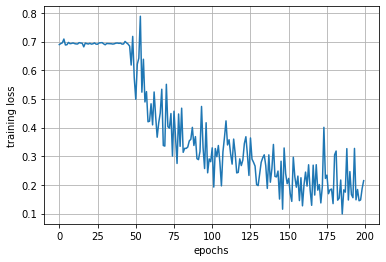

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_his)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('training loss')

Re-read the saved model for verification and found that the test accuracy is about 76%

In [7]:
restore_variables = model.ema.variables_to_restore()
saver = tf.train.Saver(restore_variables)

with tf.Session() as sess:
    #ckpt = tf.train.get_checkpoint_state('ckpt')
    saver.restore(sess, 'ckpt/lstm_model-801')
    acc = sess.run([model.acc],
                   {model.data: Xts, model.label: yts, model.emb_dropout: 1.0, model.rnn_dropout: 1.0})
    print ('test acc is {}'.format(acc))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ckpt/lstm_model-801
test acc is [0.76243097]


Plot the train accuracy vs. test accuracy. 

The training accuracy will converage to about 93%, and the test accuracy will converge to about 76%.

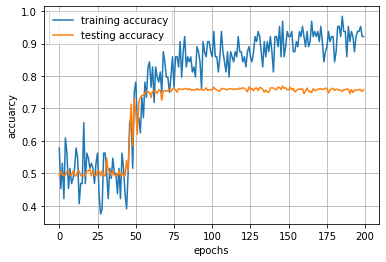

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(acc_his)
plt.plot(acc2_his)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'testing accuracy'])